# Mask R-CNN demo

This notebook illustrates one possible way of using `maskrcnn_benchmark` for computing predictions on images from an arbitrary URL.

Let's start with a few standard imports

In [1]:
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab

import requests
from io import BytesIO
from PIL import Image
import numpy as np

In [2]:
# this makes our figures bigger
pylab.rcParams['figure.figsize'] = 20, 12

Those are the relevant imports for the detection model

In [3]:
from maskrcnn_benchmark.config import cfg
from predictor import COCODemo

We provide a helper class `COCODemo`, which loads a model from the config file, and performs pre-processing, model prediction and post-processing for us.

We can configure several model options by overriding the config options.
In here, we make the model run on the CPU

In [4]:
config_file = "../configs/caffe2/e2e_mask_rcnn_R_50_FPN_1x_caffe2.yaml"

# update the config options with the config file
cfg.merge_from_file(config_file)
# manual override some options
# cfg.merge_from_list(["MODEL.DEVICE", "cpu"])

Now we create the `COCODemo` object. It contains a few extra options for conveniency, such as the confidence threshold for detections to be shown.

In [5]:
coco_demo = COCODemo(
    cfg,
    min_image_size=800,
    confidence_threshold=0.7,
)

Let's define a few helper functions for loading images from a URL

In [6]:
def load(url):
    """
    Given an url of an image, downloads the image and
    returns a PIL image
    """
    response = requests.get(url)
    pil_image = Image.open(BytesIO(response.content)).convert("RGB")
    # convert to BGR format
    image = np.array(pil_image)[:, :, [2, 1, 0]]
    return image

def imread(path):
    pil_image = Image.open(path).convert("RGB")
    # convert to BGR format
    image = np.array(pil_image)[:, :, [2, 1, 0]]
    return image

def imshow(img):
    plt.imshow(img[:, :, [2, 1, 0]])
    plt.axis("off")

### Load COCO image
- https://github.com/cocodataset/cocoapi/blob/master/PythonAPI/pycocoDemo.ipynb
- https://github.com/cocodataset/cocoapi/blob/master/PythonAPI/pycocoEvalDemo.ipynb

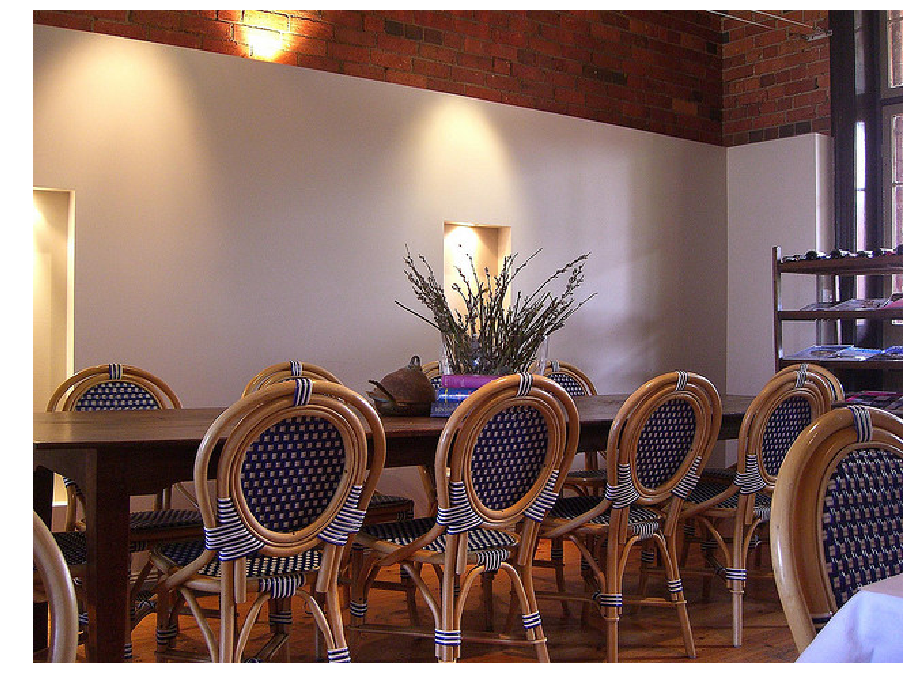

In [7]:
# from http://cocodataset.org/#explore?id=345434
# image = load("http://farm3.staticflickr.com/2469/3915380994_2e611b1779_z.jpg")
image = imread('/home/v-yuclo/coco_dataset/train2014/COCO_train2014_000000057870.jpg')
imshow(image)

In [8]:
type(image), image.shape

(numpy.ndarray, (480, 640, 3))

### Read COCO annotation

In [9]:
from pycocotools.coco import COCO

In [10]:
coco = COCO('/home/v-yuclo/coco_dataset/annotations_trainval2014/annotations/instances_train2014.json')

loading annotations into memory...
Done (t=9.74s)
creating index...
index created!


In [104]:
# Make coco_orig_id2name lookup table
coco_orig_name2id = {v['name']: v['id'] for v in coco.cats.values()}
coco_orig_id2name = {v: k for k, v in coco_orig_name2id.items()}

In [13]:
"""
coco.imgs

{57870: {'license': 5,
  'file_name': 'COCO_train2014_000000057870.jpg',
  'coco_url': 'http://images.cocodataset.org/train2014/COCO_train2014_000000057870.jpg',
  'height': 480,
  'width': 640,
  'date_captured': '2013-11-14 16:28:13',
  'flickr_url': 'http://farm4.staticflickr.com/3153/2970773875_164f0c0b83_z.jpg',
  'id': 57870},
 384029: {'license': 5,
  'file_name': 'COCO_train2014_000000384029.jpg',
  'coco_url': 'http://images.cocodataset.org/train2014/COCO_train2014_000000384029.jpg',
  'height': 429,
  'width': 640,
  'date_captured': '2013-11-14 16:29:45',
  'flickr_url': 'http://farm3.staticflickr.com/2422/3577229611_3a3235458a_z.jpg',
  'id': 384029}, ...
}

"""

"\ncoco.imgs\n\n{57870: {'license': 5,\n  'file_name': 'COCO_train2014_000000057870.jpg',\n  'coco_url': 'http://images.cocodataset.org/train2014/COCO_train2014_000000057870.jpg',\n  'height': 480,\n  'width': 640,\n  'date_captured': '2013-11-14 16:28:13',\n  'flickr_url': 'http://farm4.staticflickr.com/3153/2970773875_164f0c0b83_z.jpg',\n  'id': 57870},\n 384029: {'license': 5,\n  'file_name': 'COCO_train2014_000000384029.jpg',\n  'coco_url': 'http://images.cocodataset.org/train2014/COCO_train2014_000000384029.jpg',\n  'height': 429,\n  'width': 640,\n  'date_captured': '2013-11-14 16:29:45',\n  'flickr_url': 'http://farm3.staticflickr.com/2422/3577229611_3a3235458a_z.jpg',\n  'id': 384029}, ...\n}\n\n"

In [82]:
imgIds = coco.getImgIds()
annIds = coco.getAnnIds()
len(imgIds), len(annIds)

(82783, 604907)

In [83]:
imgs = coco.loadImgs(imgIds)
img = imgs[0]
img

{'license': 5,
 'file_name': 'COCO_train2014_000000057870.jpg',
 'coco_url': 'http://images.cocodataset.org/train2014/COCO_train2014_000000057870.jpg',
 'height': 480,
 'width': 640,
 'date_captured': '2013-11-14 16:28:13',
 'flickr_url': 'http://farm4.staticflickr.com/3153/2970773875_164f0c0b83_z.jpg',
 'id': 57870}

In [212]:
annIds = coco.getAnnIds(imgIds=[img['id']])
anns = coco.loadAnns(annIds)
len(anns)

17

In [105]:
[ann['bbox'] for ann in anns],\
[coco_orig_id2name[ann['category_id']] for ann in anns]

([[233.29, 270.45, 170.32, 203.36],
  [1.02, 279.96, 533.09, 200.04],
  [476.76, 261.03, 119.73, 201.71],
  [10.79, 260.03, 114.33, 124.04],
  [367.82, 264.27, 139.15, 215.73],
  [539.33, 290.16, 100.67, 179.05],
  [364.4, 256.57, 52.66, 26.64],
  [152.17, 256.67, 78.41, 29.11],
  [1.08, 373.21, 31.28, 106.79],
  [298.2, 235.17, 83.01, 34.08],
  [285.8, 257.46, 13.97, 16.14],
  [20.54, 376.76, 83.24, 55.13],
  [263.03, 174.37, 154.64, 125.03],
  [560.8, 413.95, 78.29, 65.25],
  [296.78, 277.79, 32.48, 11.99],
  [292.8, 289.31, 21.41, 11.34],
  [90.67, 271.49, 171.84, 208.51]],
 ['chair',
  'dining table',
  'chair',
  'chair',
  'chair',
  'chair',
  'chair',
  'chair',
  'chair',
  'vase',
  'chair',
  'chair',
  'potted plant',
  'dining table',
  'book',
  'book',
  'chair'])

### Computing the predictions

We provide a `run_on_opencv_image` function, which takes an image as it was loaded by OpenCV (in `BGR` format), and computes the predictions on them, returning an image with the predictions overlayed on the image.

CPU times: user 394 ms, sys: 99.6 ms, total: 493 ms
Wall time: 440 ms


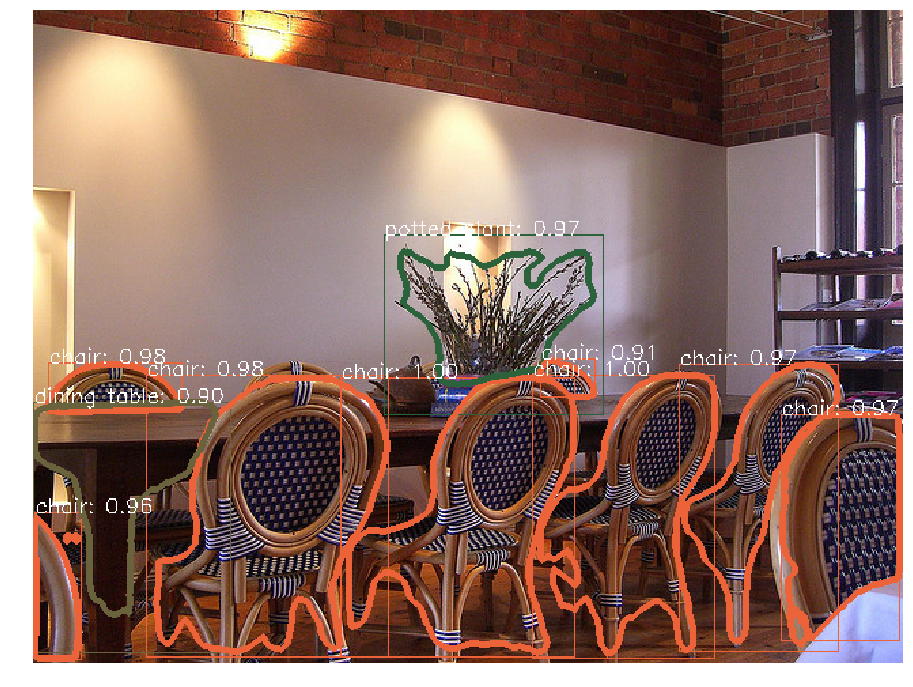

In [134]:
%%time

# compute predictions
result, predictions = coco_demo.run_on_opencv_image(image, return_predictions=True)
imshow(result)

In [135]:
result.shape

(480, 640, 3)

In [136]:
predictions.fields()

['labels', 'scores', 'mask']

In [220]:
predictions.fields()

['labels', 'scores', 'mask']

In [ ]:
predictions.

In [137]:
predictions.get_field('labels').cpu().tolist(),\
[coco_demo.CATEGORIES[i] for i in predictions.get_field('labels').cpu().tolist()]

([57, 57, 57, 57, 57, 57, 59, 57, 57, 61],
 ['chair',
  'chair',
  'chair',
  'chair',
  'chair',
  'chair',
  'potted plant',
  'chair',
  'chair',
  'dining table'])

In [138]:
predictions.get_field('scores').cpu().tolist()

[0.9972099661827087,
 0.9961643218994141,
 0.9825208783149719,
 0.9815482497215271,
 0.9716094732284546,
 0.9700285196304321,
 0.9679906368255615,
 0.9563686847686768,
 0.9052027463912964,
 0.902910590171814]

In [229]:
predictions.get_field('mask').cpu().numpy().shape

(10, 1, 480, 640)

In [140]:
predictions.bbox.cpu().tolist()

[[367.2793273925781,
  268.2576904296875,
  501.25042724609375,
  476.32879638671875],
 [226.146484375, 270.0175476074219, 398.5008544921875, 475.16943359375],
 [83.84686279296875, 268.9591064453125, 261.91693115234375, 475.8228759765625],
 [11.483559608459473,
  259.9708251953125,
  109.58409118652344,
  294.93060302734375],
 [475.78192138671875,
  260.33428955078125,
  592.2647705078125,
  471.3994445800781],
 [550.9171142578125, 297.3614807128906, 637.1371459960938, 463.8026428222656],
 [258.6116638183594, 165.12506103515625, 419.3072509765625, 297.637451171875],
 [1.005253553390503, 369.2379455566406, 35.29096603393555, 477.01251220703125],
 [373.1956787109375, 256.9950866699219, 413.3497314453125, 284.6089782714844],
 [0.0, 288.2123107910156, 145.96910095214844, 472.2884216308594]]

In [230]:
# Combine 'label', 'score', 'mask' to a single prediction object.
formated_predictions = [{
    'category_id': coco_orig_name2id[coco_demo.CATEGORIES[cid]], # map coco_demo's id to original coco ids.
    'category_name': coco_demo.CATEGORIES[cid],
    'score': score,
    'mask': mask,
    'bbox': bbox
} for cid, score, mask, bbox in zip(
    predictions.get_field('labels').cpu().tolist(),
    predictions.get_field('scores').cpu().tolist(),
    predictions.get_field('mask').cpu().numpy(),
    predictions.bbox.cpu().tolist()
)]

In [231]:
formated_predictions[0]

{'category_id': 62,
 'category_name': 'chair',
 'score': 0.9972099661827087,
 'mask': array([[[0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         ...,
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0]]], dtype=uint8),
 'bbox': [367.2793273925781,
  268.2576904296875,
  501.25042724609375,
  476.32879638671875]}

### Compute IOU (Align predictions to ground truths)

In [35]:
import sys
sys.path.append('/home/v-yuclo/cocoapi/PythonAPI/pycocotools/')
import mask as maskUtils

In [155]:
g = [g['bbox'] for g in anns]
d = predictions.bbox.cpu().numpy().copy() # xyxy
d[:,[2,3]] -= d[:,[0,1]] # xywh
iscrowd = [int(g['iscrowd']) for g in anns]

In [142]:
g

[[233.29, 270.45, 170.32, 203.36],
 [1.02, 279.96, 533.09, 200.04],
 [476.76, 261.03, 119.73, 201.71],
 [10.79, 260.03, 114.33, 124.04],
 [367.82, 264.27, 139.15, 215.73],
 [539.33, 290.16, 100.67, 179.05],
 [364.4, 256.57, 52.66, 26.64],
 [152.17, 256.67, 78.41, 29.11],
 [1.08, 373.21, 31.28, 106.79],
 [298.2, 235.17, 83.01, 34.08],
 [285.8, 257.46, 13.97, 16.14],
 [20.54, 376.76, 83.24, 55.13],
 [263.03, 174.37, 154.64, 125.03],
 [560.8, 413.95, 78.29, 65.25],
 [296.78, 277.79, 32.48, 11.99],
 [292.8, 289.31, 21.41, 11.34],
 [90.67, 271.49, 171.84, 208.51]]

In [156]:
d.tolist()

array([[367.27933  , 268.2577   , 133.9711   , 208.0711   ],
       [226.14648  , 270.01755  , 172.35437  , 205.15189  ],
       [ 83.84686  , 268.9591   , 178.07007  , 206.86377  ],
       [ 11.48356  , 259.97083  ,  98.10053  ,  34.959778 ],
       [475.78192  , 260.3343   , 116.48285  , 211.06516  ],
       [550.9171   , 297.36148  ,  86.22003  , 166.44116  ],
       [258.61166  , 165.12506  , 160.69559  , 132.51239  ],
       [  1.0052536, 369.23795  ,  34.285713 , 107.77457  ],
       [373.19568  , 256.9951   ,  40.154053 ,  27.613892 ],
       [  0.       , 288.2123   , 145.9691   , 184.07611  ]],
      dtype=float32)

In [48]:
len(g), len(d)

(17, 10)

In [183]:
ious = maskUtils.iou(d, g, iscrowd)

In [184]:
ious.shape

(10, 17)

In [159]:
len(anns)

17

In [232]:
ious.max(axis=-1) >= iou_threshold

array([ True,  True,  True, False,  True,  True,  True,  True,  True,
       False])

In [239]:
 # Match ground-truth bbox ids 
iou_threshold = 0.5
keeps = ious.max(axis=-1) >= iou_threshold
prediction_ann_ids = ious.argmax(axis=-1)
keeps, prediction_ann_ids

(array([ True,  True,  True, False,  True,  True,  True,  True,  True,
        False]), array([ 4,  0, 16,  3,  2,  5, 12,  8,  6,  3]))

In [ ]:
predictions.get_field('scores').cpu().numpy()

In [197]:
predictable_anns = [ann for i, ann in enumerate(anns) if i in predictable_ann_ids]

In [ ]:
predictable

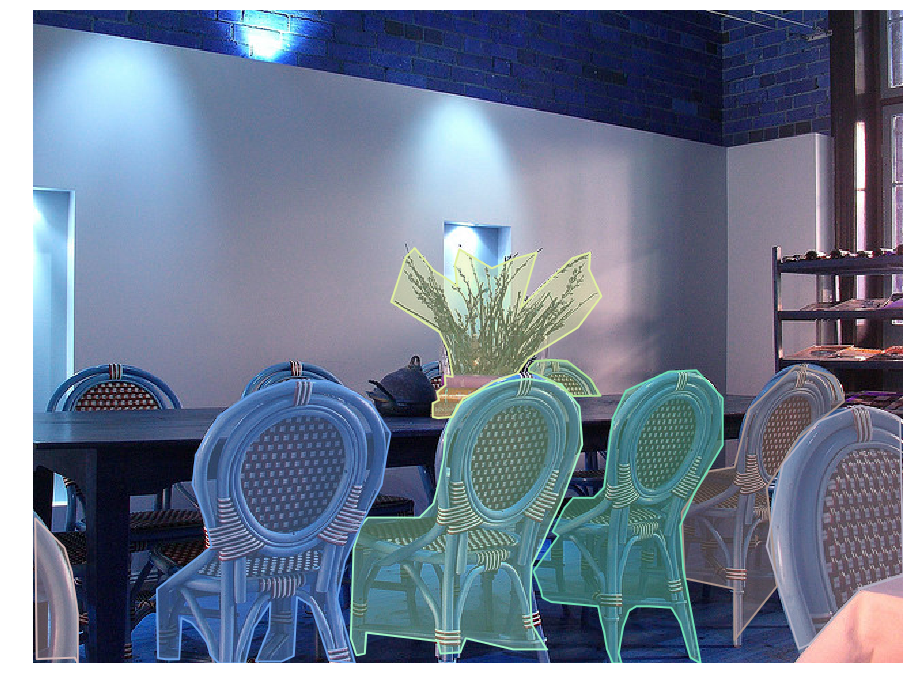

In [198]:
plt.imshow(image); plt.axis('off')
coco.showAnns(predictable_anns)

In [240]:
import pickle
with open('coco_train2014_e2e_mask_rcnn_R_101_FPN_1x_caffe2.pkl', 'rb') as file:
    new_anns = pickle.load(file) 

In [ ]:
[i for ann in enumerate(new_anns[57870]) if 'prediction' in ann.keys()]

AttributeError: 'tuple' object has no attribute 'keys'

## Keypoints Demo

In [9]:
# set up demo for keypoints
config_file = "../configs/caffe2/e2e_keypoint_rcnn_R_50_FPN_1x_caffe2.yaml"
cfg.merge_from_file(config_file)
cfg.merge_from_list(["MODEL.DEVICE", "cpu"])
cfg.merge_from_list(["MODEL.MASK_ON", False])

coco_demo = COCODemo(
    cfg,
    min_image_size=800,
    confidence_threshold=0.7,
)

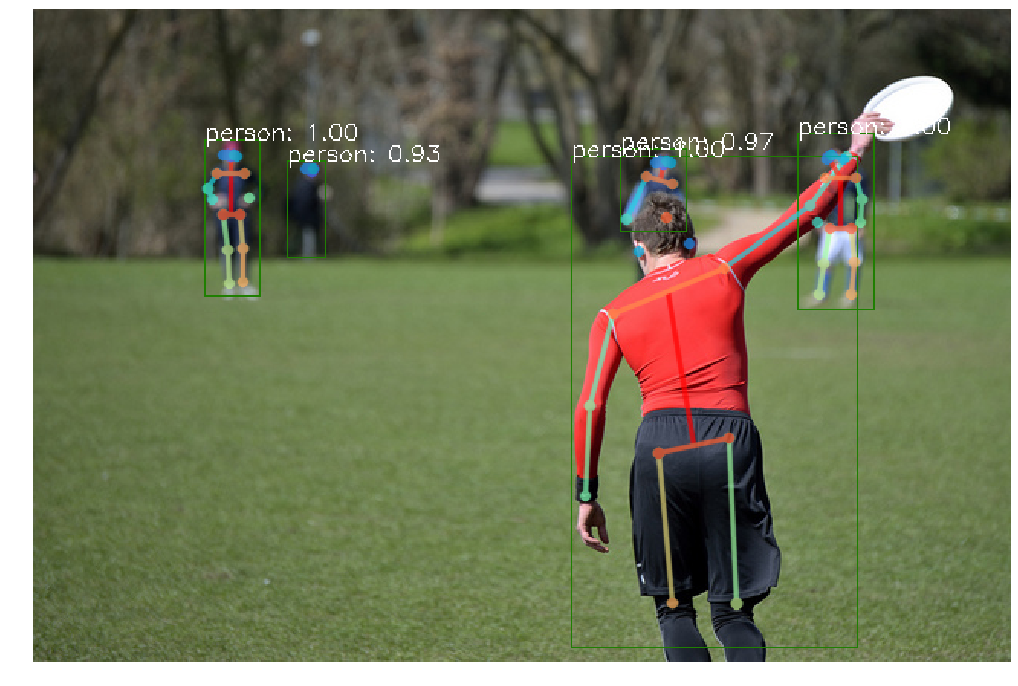

In [10]:
# run demo
image = load("http://farm9.staticflickr.com/8419/8710147224_ff637cc4fc_z.jpg")
predictions = coco_demo.run_on_opencv_image(image)
imshow(predictions)